<br><br><br>


<span style="color:red;font-size:60px">PySpark ML Practice Assignment</span>
<br><br><br>
In this assignment, we'll compare the results of a random forest classifier with the results from a logistic regression classifier on the California housing data. Working with python gives us access to easy graphics (matplotlib.pyplot) so we can draw ROC curves and precision-recall curves easily. We'll also get some practice with other feature transformers available in Spark.

Just follow the steps below - carefully - and you should not have a problem


<br><br><br>
<span style="color:green;font-size:xx-large">STEP 1: Initialize PySpark</span>

In [1]:
#Pyspark initialization code goes here
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark ML Practice Assignment").getOrCreate()
sc = spark.sparkContext


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/18 23:14:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/18 23:14:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/18 23:14:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


<br><br><br>
<span style="color:green;font-size:xx-large">STEP 2: necessary imports</span>
<li>I've done these, hopefully, for you</li>

In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 3: Read the data and split into training and testing sets</span>
<li>Convert the Scala Spark function into a PySpark function</li>

In [3]:
from pyspark.sql import DataFrame


def readData(): 
    df = spark.read.format("csv").option('header',"false").option("inferschema","true").load("cal_housing.data")\
    .toDF("Longitude","Latitude","MedianAge",
                             "TotalRooms","TotalBedrooms","Population","Households",
                             "MedianIncome","MedianHomeValue")

    train,test = df.randomSplit((0.8,0.2),seed=1234)
    return train,test

train,test = readData()

In [4]:
train

DataFrame[Longitude: double, Latitude: double, MedianAge: double, TotalRooms: double, TotalBedrooms: double, Population: double, Households: double, MedianIncome: double, MedianHomeValue: double]

In [5]:
test

DataFrame[Longitude: double, Latitude: double, MedianAge: double, TotalRooms: double, TotalBedrooms: double, Population: double, Households: double, MedianIncome: double, MedianHomeValue: double]

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 4: Write the prepareData function</span>
<li>Convert the Scala Spark function into a PySpark function</li>

In [6]:
from pyspark.sql import DataFrame


def prepareData(df): 

    df = df.withColumn("MedianHomeValue",col("MedianHomeValue")/100000)\
        .withColumn("RoomsPerHouse", col("TotalRooms")/col("Households"))\
        .withColumn("PeoplePerHouse", col("Population")/col("Households"))\
        .withColumn("BedroomsPerHouse", col("TotalBedrooms")/col("Households"))\
        .select("MedianHomeValue", "MedianAge", "Population", "Households", 
                "MedianIncome", "RoomsPerHouse", "PeoplePerHouse", 
                      "BedroomsPerHouse", "Latitude","Longitude")


    return df



In [7]:
train = prepareData(train)
test = prepareData(test)

# train.printSchema

<bound method DataFrame.printSchema of DataFrame[MedianHomeValue: double, MedianAge: double, Population: double, Households: double, MedianIncome: double, RoomsPerHouse: double, PeoplePerHouse: double, BedroomsPerHouse: double, Latitude: double, Longitude: double]>

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 5: Transform the dependent variable into two buckets</span>

<li>Use QuantileDiscretizer with two buckets</li>
<li>QuantileDiscretizer bins a continuous column into n buckets across the range of values in that column</li>
<li>When n=2, we'll get 0 and 1 as the two values setting up the dv as a binary classification problem</li>
<li>Note: In this case, the interpretation of the dv is:
    <ul>
        <li>0: low median housing value</li>
        <li>1: high median housing value</li>
    </ul>
<li><a href="https://spark.apache.org/docs/latest/ml-features#quantilediscretizer">https://spark.apache.org/docs/latest/ml-features#quantilediscretizer</a></li>


In [8]:

discretizer = QuantileDiscretizer().setInputCol("MedianHomeValue").setOutputCol("DVBucket").setNumBuckets(2)
bucketizer = discretizer.fit(train)
bucketed = bucketizer.transform(train)

In [9]:
bucketed
# discretizer

DataFrame[MedianHomeValue: double, MedianAge: double, Population: double, Households: double, MedianIncome: double, RoomsPerHouse: double, PeoplePerHouse: double, BedroomsPerHouse: double, Latitude: double, Longitude: double, DVBucket: double]

In [10]:
train

DataFrame[MedianHomeValue: double, MedianAge: double, Population: double, Households: double, MedianIncome: double, RoomsPerHouse: double, PeoplePerHouse: double, BedroomsPerHouse: double, Latitude: double, Longitude: double]

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 6: Assemble the independent variables in a features vector</span>
<li>Use VectorAssembler for this (the same as what we did in the class!</li>

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Matrix, Vectors

#Get the names of all columns except MedianHomeValue
cols = train.columns
cols.remove("MedianHomeValue")

#Create a vectorassembler from the list of columns and specify the name of the column of vectors
assembler =  VectorAssembler().setInputCols(("MedianAge","Population", "Households", 
                        "MedianIncome", "RoomsPerHouse", "PeoplePerHouse", "BedroomsPerHouse"))\
                        .setOutputCol("features")


#Apply the transform function on the data frame, select the dv and features column
#And rename the dv column to label

vector_df = assembler.transform(train)\
                     .select("MedianHomeValue","features")\
                     .withColumnRenamed("MedianHomeValue","label")


vector_df.show()

# cols




+-----+--------------------+
|label|            features|
+-----+--------------------+
|0.946|[52.0,806.0,270.0...|
|1.036|[17.0,1244.0,456....|
| 0.79|[36.0,1194.0,465....|
|0.761|[32.0,434.0,187.0...|
|1.067|[52.0,1152.0,435....|
|0.508|[52.0,544.0,172.0...|
|0.732|[11.0,1343.0,479....|
|0.783|[28.0,1530.0,653....|
|0.581|[32.0,620.0,268.0...|
|0.669|[20.0,1993.0,721....|
|0.684|[17.0,1947.0,647....|
|0.901|[21.0,2907.0,972....|
| 0.69|[30.0,1367.0,583....|
|  0.7|[37.0,640.0,260.0...|
|0.746|[15.0,1645.0,640....|
| 1.07|[35.0,480.0,179.0...|
|0.722|[33.0,656.0,236.0...|
| 0.67|[34.0,950.0,317.0...|
|0.702|[37.0,867.0,310.0...|
|0.646|[40.0,788.0,279.0...|
+-----+--------------------+
only showing top 20 rows



<br><br><br><br>
<span style="color:red;font-size:40px">ML Models: Logistic Regression and Random Forest</span>
<br><br>
In this assignment, we'll build a logistic regression model and a random forest classifer and then compare the results on the two models. For this, we need to do the following:
<li>Create a pipeline for the logistic regression model</li>
<li>Create a pipeline for the random forest model</li>
<li>Evaluate and compare both models</li>
<li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html">https://spark.apache.org/docs/latest/ml-classification-regression.html</a></li>

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 7: Create the two classifers</span>



In [12]:
#I've done this

rrr = RandomForestClassifier()\
    .setFeaturesCol("features")\
    .setLabelCol("DVBucket")

logrr = LogisticRegression()\
    .setFeaturesCol("features")\
    .setLabelCol("DVBucket")




<br><br><br>
<span style="color:green;font-size:xx-large">STEP 8: Create the two pipelines</span>

<li>Create p1 with two stages: the bucketizer that uses QuantileDiscretizer and the assembler</li>
<li>Create p2 with two stages: p1 and logistic regression</li>
<li>Create p3 with two stages: p1 and random forest classifier</li>

In [13]:
# import org.apache.spark.ml.{Pipeline, PipelineModel}

p1 =Pipeline().setStages((discretizer,assembler))
p2 = Pipeline().setStages((p1,logrr))
p3 = Pipeline().setStages((p1,rrr))







<br><br><br>
<span style="color:green;font-size:xx-large">STEP 9: Run the two pipelines with training data</span>


In [14]:
lrmodel = p2.fit(train)
rcmodel = p3.fit(train)

22/04/18 23:14:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/18 23:14:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


<br><br><br>
<span style="color:green;font-size:xx-large">STEP 10: Get predictions for both models</span>



In [15]:
lr_pred = lrmodel.transform(test)
rc_pred = rcmodel.transform(test)
lr_pred

DataFrame[MedianHomeValue: double, MedianAge: double, Population: double, Households: double, MedianIncome: double, RoomsPerHouse: double, PeoplePerHouse: double, BedroomsPerHouse: double, Latitude: double, Longitude: double, DVBucket: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 11: Print testing stats for each model</span>
<li>Accuracy</li>
<li>Area under ROC</li>
<li>Area under Precision-Recall curve</li>
<li>Use <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html#pyspark.ml.evaluation.BinaryClassificationEvaluator.metricName">BinaryClassificationEvaluator</a> for the area under ROC and area under precision-recall curve</li>
<li>Use <a href="https://spark.apache.org/docs/latest//api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html">MulticlassClassificationEvaluator</a> for accuracy</li>

<li>You should see:</li>
<pre>
Test Area Under ROC Logisitic Regression 0.9197116200650872
Test Area Under ROC Random Forest Classifier 0.903399057330368
Test Area under PR Logistic Regression 0.921832503169575
Test Area under PR Random Forest Classifier 0.9086782460923636
Test Accuracy Logistic Regression 0.8415552855407047
Test Accuracy Random Forest Classifier 0.8177399756986634
</pre>

In [16]:
evaluator_b = BinaryClassificationEvaluator(labelCol="DVBucket").setMetricName("areaUnderPR")

evaluato_mr = MulticlassClassificationEvaluator(labelCol="DVBucket").setPredictionCol("prediction").setMetricName("accuracy")



print('Test Area Under ROC Logisitic Regression', evaluator_b.evaluate(lr_pred))
print('Test Area Under ROC Random Forest Classifier', evaluator_b.evaluate(rc_pred))
print('Test Area under PR Logistic Regression',evaluator_b.evaluate(lr_pred))
print('Test Area under PR Random Forest Classifier',evaluator_b.evaluate(rc_pred))
print("Test Accuracy Logistic Regression",evaluato_mr.evaluate(lr_pred))
print("Test Accuracy Random Forest Classifier",evaluato_mr.evaluate(rc_pred))



Test Area Under ROC Logisitic Regression 0.8887583791207764
Test Area Under ROC Random Forest Classifier 0.8704355579753259
Test Area under PR Logistic Regression 0.8887583791207764
Test Area under PR Random Forest Classifier 0.8704355579753259
Test Accuracy Logistic Regression 0.8026731470230862
Test Accuracy Random Forest Classifier 0.7946537059538274


<br><br><br>
<span style="color:green;font-size:xx-large">STEP 12: Print coefficients of the logistic regression</span>
<li>Notice how this is different from the linear regression coefficients</li>
<li>Still dominated by income but some other flavors have crept in</li>
<li>Print this out nicely formatted. Each line should contain the feature and it's coefficient. Use a pandas dataframe. Example: </li>


<pre>
	beta	feature
0	0.025761	MedianAge
1	-0.001325	Population
2	0.004379	Households
3	1.316013	MedianIncome
4	-0.239172	RoomsPerHouse
5	0.000757	PeoplePerHouse
6	1.604178	BedroomsPerHouse
7	-1.731346	Latitude
8	-1.720362	Longitude

</pre>

In [17]:
import pandas as pd
lrModel = lrmodel.stages[1]

df = pd.DataFrame(dict(zip(lrModel.coefficients,cols)).items())
df.columns=['beta','feature']
df

,beta,feature
0,0.045744,MedianAge
1,-0.001228,Population
2,0.004124,Households
3,1.657630,MedianIncome
4,-0.697683,RoomsPerHouse
5,-0.003046,PeoplePerHouse
6,3.015353,BedroomsPerHouse


<li>https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#binary-classification</li>

<br><br><br>
<span style="color:green;font-size:xx-large">STEP 13: Draw testing ROC curves</span>
<li>Arrange the two charts in a side by side grid, the first the ROC Curve for the LR model and the second the ROC curve for the RF model</li>
<li>Include the areaUnderROC values in each chart</li>
<li>For this, the easiest is to use sklearn's roc functionalities</li>
<li>The predictions contain two useful columns, the probability and the dependent value bucket</li>
<li>Extract these into a data frame</li>
<li>Note that the probability is expressed as a pair (probability of 0 and probability of 1)</li>
<li>Extract the probability of 1 from this (convert the df into an rdd, it will be easier!)</li>
<li>Also convert all values to float from Spark DoubleType (sklearn won't understand DoubleType)</li>
<li>You should see:</li>

<img src="sample roc curve output.png">

[Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

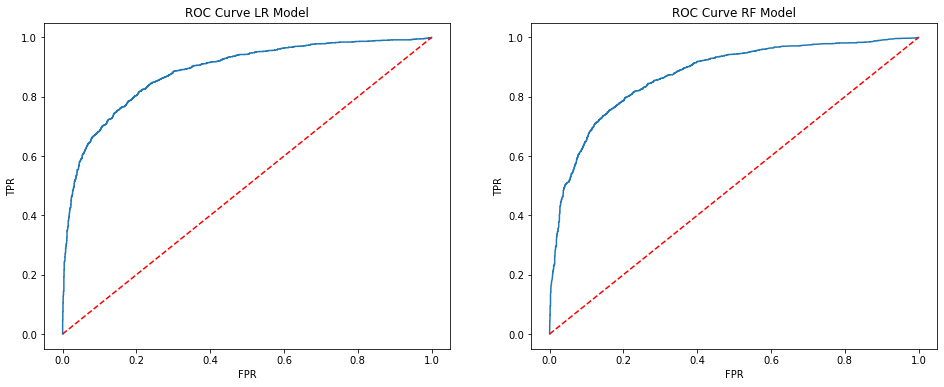

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig.suptitle = "Comparison of Models"
axes[0].set_title("ROC Curve LR Model")
axes[1].set_title("ROC Curve RF Model")


### ROC Curve LR Model
lr_predictions = lr_pred.select('DVBucket','probability')\
                        .rdd.map(lambda row: (float(row['probability'][1]), float(row['DVBucket'])))\
                        .collect()
lr_score, lr_true = zip(*lr_predictions)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(lr_true, lr_score, pos_label=1)
axes[0].plot(lr_fpr, lr_tpr)
axes[0].plot([0, 1], [0, 1], 'r--')
axes[0].set(xlabel="FPR", ylabel="TPR")

### ROC Curve RF Model
rc_predictions = rc_pred.select('DVBucket','probability')\
                        .rdd.map(lambda row: (float(row['probability'][1]), float(row['DVBucket'])))\
                        .collect()
rc_score, rc_true = zip(*rc_predictions)
rc_fpr, rc_tpr, rc_thresholds = roc_curve(rc_true, rc_score, pos_label=1)
axes[1].plot(rc_fpr, rc_tpr)
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set(xlabel="FPR", ylabel="TPR")

